### Time Series Forecasting for sales of an insurance product

#### Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Helper Functions

In [2]:
def dickeyfuller_test(X):
    '''Helper Function to check if stationary'''
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [3]:
from statsmodels.tsa.arima_model import ARIMA



#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast(steps=1)[0]
    conf = model_fit.forecast(steps=1)[2]
    if k==332:
        print(model_fit.summary())
        plt.show()
    return prediction,conf


The StartARIMAForecasting Function creates an ARIMA model. Fits() function fits ARIMA(p,d,q) model by exact maximum likelihood via Kalman filter and Forecast() returns an estimated value based on the fitted ARIMA model.

#### Data Exploration

In [5]:
# Read in the data of total trips of the lift
data = pd.read_csv('./insurance_sales.csv', header=0)
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
#data = data.set_index('Unnamed: 0').groupby([pd.Grouper(freq='D')]).max().reset_index()
data.head(10)

Date  sales
0 2009-01-01   1171
1 2009-02-01   1046
2 2009-03-01    980
3 2009-04-01    883
4 2009-05-01    877
5 2009-06-01    975
6 2009-07-01   1041
7 2009-08-01   1060
8 2009-09-01    950
9 2009-10-01    893

The dataset provided includes the total sales of an insurance product e.g. breakdown cover.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
Date     120 non-null datetime64[ns]
sales    120 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.0 KB


In [7]:
df = data[["Date","sales"]].copy()
# Check if there are rows with missing values on the data set
df.isnull().any().any()

False

#### Exclude rows with missing values

In [8]:
# Drop all rows that have any NaN values
df = df.dropna()


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 2 columns):
Date     120 non-null datetime64[ns]
sales    120 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


#### Plot time series

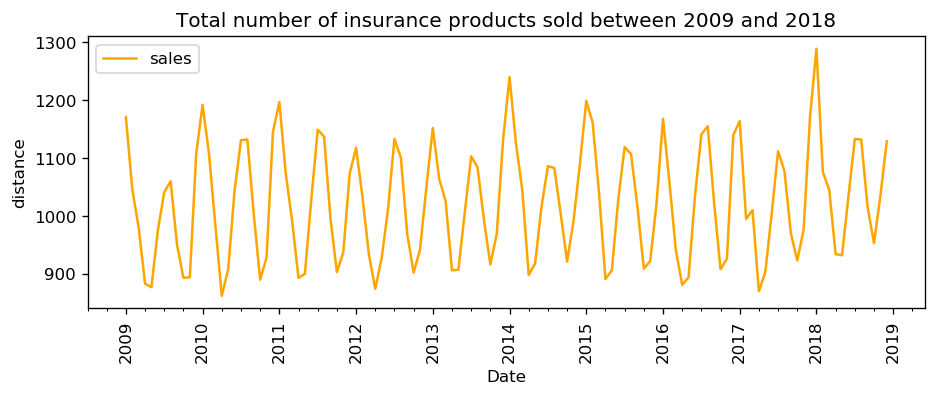

In [30]:
# Plot time series
ax = plt.gca()
df.plot(kind='line',x="Date",y="sales", color='orange', ax=ax) # Sales of an insurance product
plt.ylabel("distance")
plt.xticks(rotation='vertical')
plt.title("Total number of insurance products sold between 2009 and 2018")

plt.show()

From the plot, the time series appears to vary between 800 sales and 1300 sales depending on the time of year.

#### Exclude extreme values

In [11]:
df = df.loc[(df.sales > 0)] # Exclude extreme values

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 2 columns):
Date     120 non-null datetime64[ns]
sales    120 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


### Does the data set show a seasonality component?

We will decompose the data to view the trend and seasonal pattern.  A seasonal element is clearly seen.

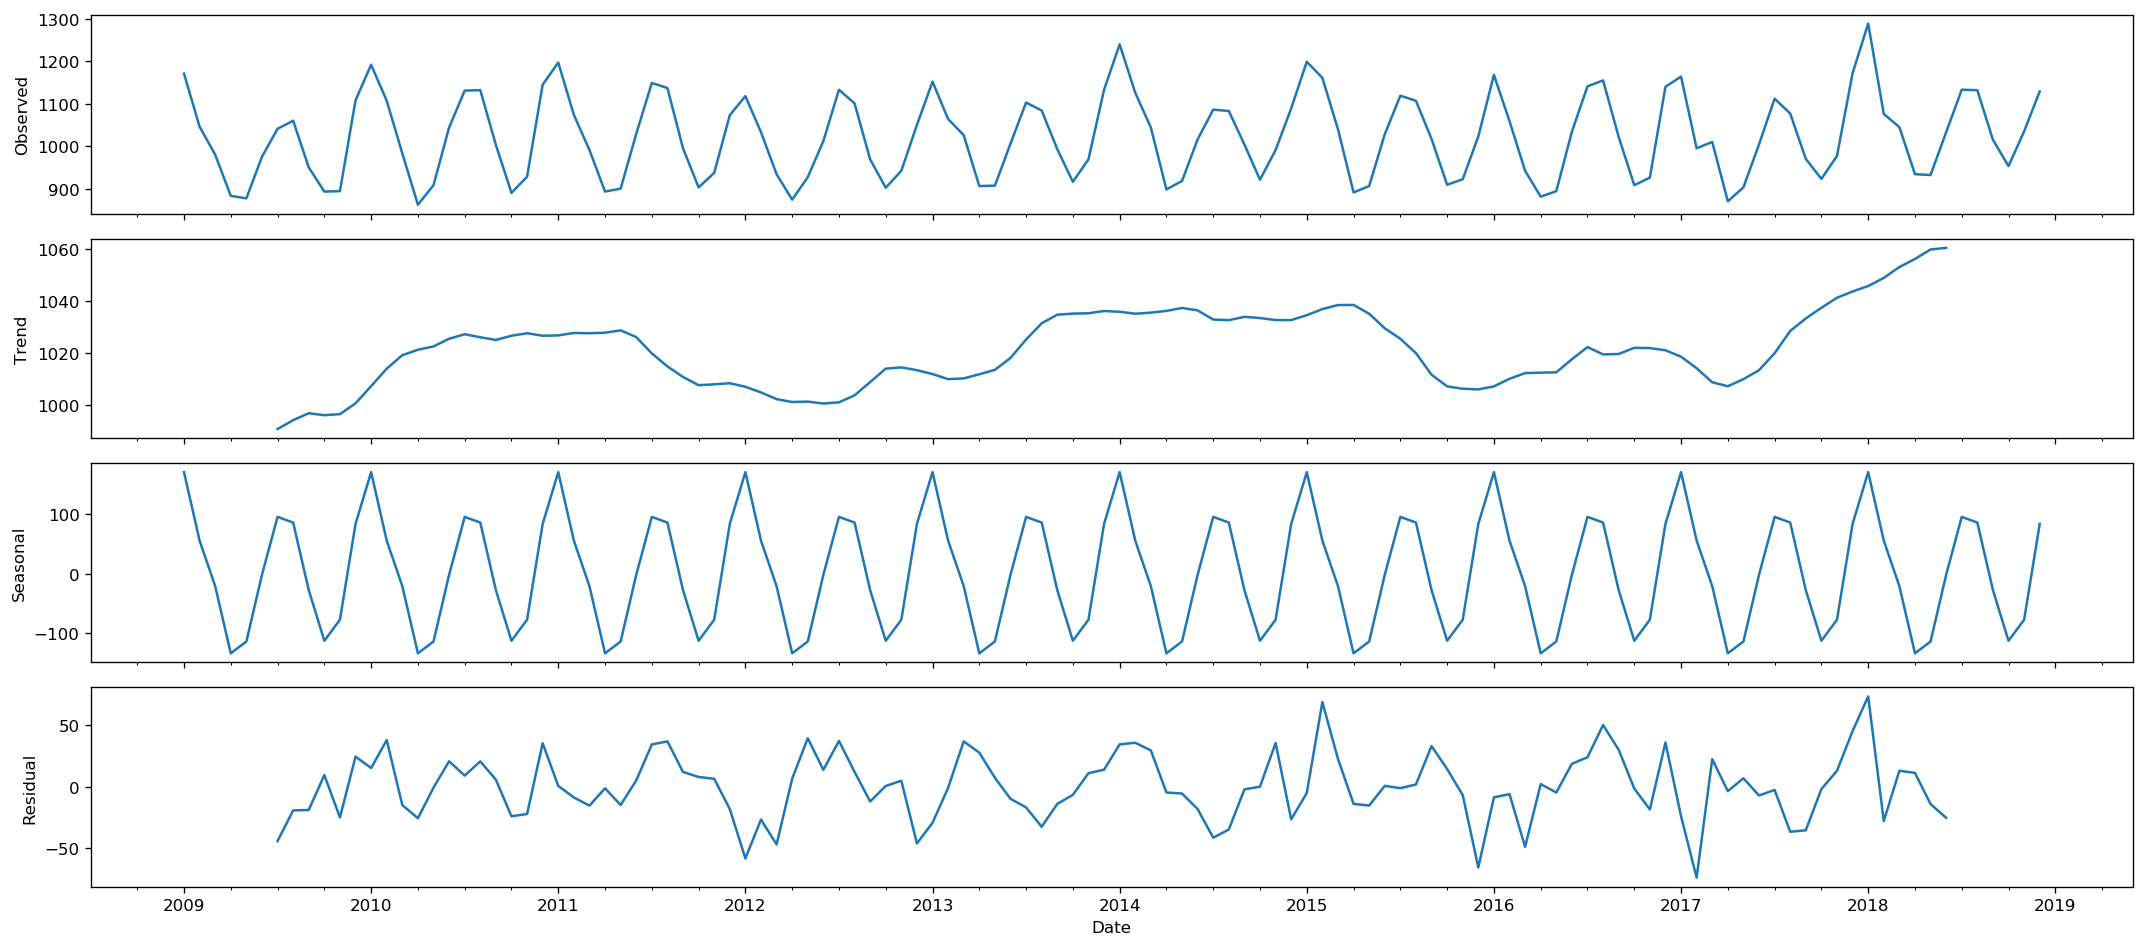

In [34]:
y = df.set_index(['Date'])
y.head(5)

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()



### Rolling Forecast Seasonal Auto Regressive Moving Average (SARIMA) Model 

#### Choose parameters
There is an automatic ARIMA package in Python that will find the best model for your data. In the time series, there is clearly a seasonal element whereby the number of sales increases and decreases on a cyclic nature throughout the year so we will perform the auto arima function with a yearly seasonal component (m=12 because we have monthly data).  For SARIMA, our data set has to be stationary (have a constant mean and variance).  If not, the data set is differenced.  The auto arima determines this via the Augmented Dicky Fuller (ADF) test and differences the data set if necessary.

In [29]:

import pmdarima as pm


model = pm.auto_arima(df.sales, start_p=1, start_q=1, 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1,              # D=1 if it has a well defined seasonal pattern which it does here
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=1065.051, BIC=1078.462, Fit time=0.718 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=1122.603, BIC=1127.968, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=1085.309, BIC=1096.037, Fit time=0.306 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=1067.244, BIC=1077.972, Fit time=0.535 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=1064.478, BIC=1080.571, Fit time=0.413 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=1087.210, BIC=1100.621, Fit time=0.427 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=1063.017, BIC=1081.792, Fit time=2.647 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=1063.804, BIC=1079.897, Fit time=2.156 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_orde

The results of the _auto-arima_ function show that the SARIMA model with the lowest AIC and BIC is SARIMA(1,0,0) with seasonal order (0,1,2,12).  The value of 12 indicates a yearly cycle.  Here it shows that the seasonal element was differenced to enable stationarity.

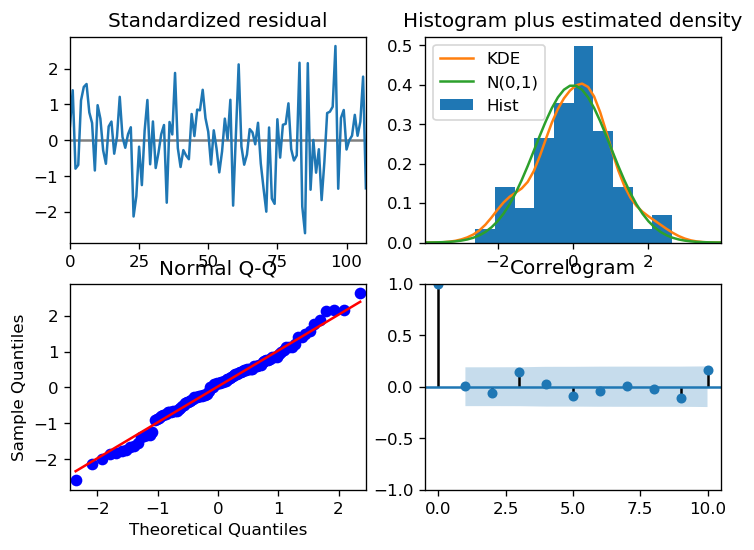

                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(0, 1, 2, 12)   Log Likelihood                -525.080
Date:                            Thu, 19 Sep 2019   AIC                           1060.160
Time:                                    08:00:15   BIC                           1073.570
Sample:                                         0   HQIC                          1065.597
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4393      1.084      2.251      0.024       0.315       4.563
ar.L1          0.4776      0.075   

In [19]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

# SARIMA Model
model = SARIMAX(df.sales, order=(1,0,0), seasonal_order=(0,1,2,12),trend='c',enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())




### _Split to train and test set_
To train the model, 90% of the data with the remaining 10% to test the accuracy.


In [20]:
NumberOfElements = len(df.sales)
TrainingSize = int(NumberOfElements * 0.9)
train = df.sales[0:TrainingSize]
test = df.sales[TrainingSize:NumberOfElements]


C:\Users\scmcw5\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


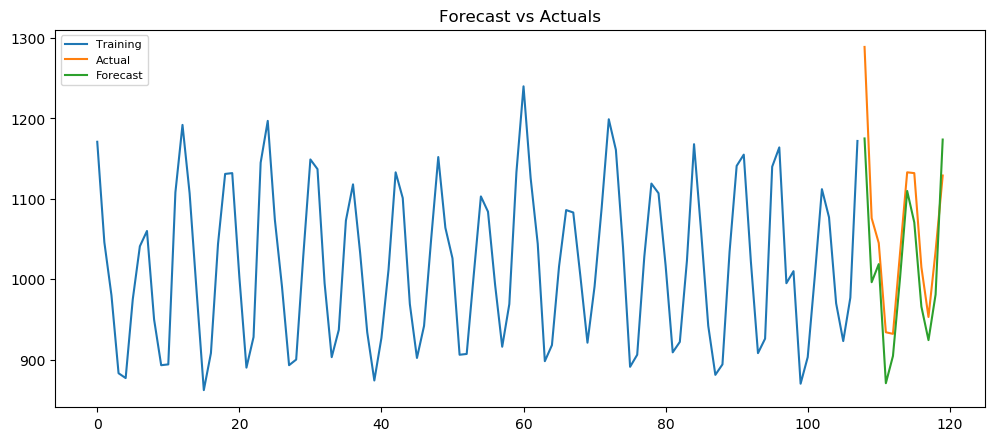

In [31]:
# Build Model
model = SARIMAX(train, order=(1, 0, 0), 
                seasonal_order=(0,1,2,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)  
fitted = model.fit()  


#Forecast 24 steps ahead
forecast_values=fitted.get_forecast(steps=12)
#Confidence intrevals for forecast
forecast_ci=forecast_values.conf_int()


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(forecast_values.predicted_mean, label='Forecast')

#plt.fill_between(forecast_ci.index,
#               forecast_ci.iloc[:,0],
#               forecast_ci.iloc[:,1], color = 'k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

###### Accuracy metrics

In [32]:
y_forecasted=forecast_values.predicted_mean
actual=df.sales

In [35]:
# Define accuracy metrics

def forecast_accuracy(y_forecasted, actual):
    mape = (abs(y_forecasted - actual)/abs(actual)).mean()  # Mean Absolute Percentage Error
    me = (y_forecasted - actual).mean()                     # Mean Error
    mse=((y_forecasted-actual)**2).mean()                   # Mean Square Error
    mae = (abs(y_forecasted - actual)).mean()               # Mean Absolute Error
    mpe = ((y_forecasted - actual)/actual).mean()           # Mean Percentage Error
    rmse = (((y_forecasted - actual)**2)).mean()**.5        # Root Mean Square Error
    return({'mape':mape, 'me':me, 'mse':mse, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse}), 

forecast_accuracy(y_forecasted, actual)

({'mape': 0.04666954784725504,
  'me': -42.78511909791311,
  'mse': 3184.3091265290172,
  'mae': 50.24656085420028,
  'mpe': -0.040060653466132655,
  'rmse': 56.42968302701174},)

The MAPE implies the model is about 95.3% accurate in predicting the next 12 observations (i.e. for 2018). Let us now forecast using our model for the next year (2019).

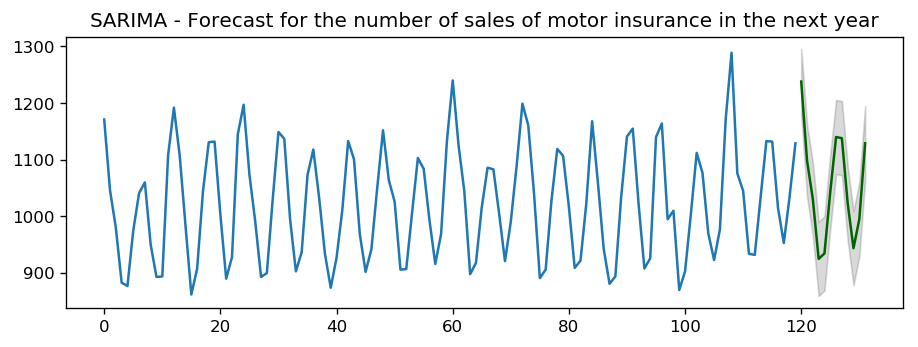

In [27]:
# Forecast
n_periods = 12
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.sales), len(df.sales)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.sales)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast for the number of sales of motor insurance in the next year")
plt.show()